# Auswertung von

## Fragestelllung

## Imports

In [598]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
import pylab 

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.anova import AnovaRM

from statistics import mean, stdev
from math import sqrt
from researchpy import ttest as rpTtest

# low level stats
from scipy.stats import shapiro
from scipy.stats import ttest_ind

# easier stats
import pingouin as pg

In [599]:
## def some functions for cf
def cf(data):
    return st.t.interval(confidence=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

def cf_lower(data):
    return cf(data)[0]

def cf_upper(data):
    return cf(data)[1]

def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

## Einlesen der Daten
### Allgemeine Informationen
### Benötigte Daten

### Import der log.csv Datei

In [600]:
df_data = pd.read_csv('data/log.csv')

df_data

,id,timestamp,scene,framerate,marker,rating
0,0,2023-08-30 15:25:14.725912,image,120,point,5
1,0,2023-08-30 15:25:27.219762,image,120,aruco,4
2,0,2023-08-30 15:25:33.355089,image,120,qr,5
3,0,2023-08-30 15:25:39.971170,text_w,120,point,5
4,0,2023-08-30 15:25:47.068685,text_w,120,aruco,5
...,...,...,...,...,...,...
1111,6,2023-09-29 11:32:52.218356,text_d,240,none,5
1112,6,2023-09-29 11:32:58.196500,text_w,240,aruco,5
1113,6,2023-09-29 11:33:04.164519,text_w,240,point,5
1114,6,2023-09-29 11:33:09.959571,text_w,240,qr,5


In [601]:
## Create new empty Dataframe
df_sorted_data = pd.DataFrame(columns=["id"])



df_balance = df_data.pivot_table(index=['id'], columns=['scene', 'framerate', 'marker'],
                     values='rating', aggfunc='mean').reset_index()

df_balance.columns = df_balance.columns.map(lambda t: str(t[0]) + "_" + str(t[1]) + "_" + str(t[2]))
## add the dataframe to the sorted data to have it sorted
df_sorted_data = pd.concat([df_sorted_data, df_balance.rename(columns={"id__": "id"})])

## uncomment below to show values ##

df_sorted_data


,id,image_60_aruco,image_60_point,image_60_qr,image_120_aruco,image_120_none,image_120_point,image_120_qr,image_144_aruco,image_144_none,...,text_w_144_point,text_w_144_qr,text_w_200_aruco,text_w_200_none,text_w_200_point,text_w_200_qr,text_w_240_aruco,text_w_240_none,text_w_240_point,text_w_240_qr
0,0,1.0,1.0,1.0,4.666667,NaN,4.333333,4.333333,5.000000,NaN,...,4.666667,5.000000,NaN,NaN,NaN,NaN,4.666667,NaN,5.0,5.000000
1,1,NaN,NaN,NaN,5.000000,5.000000,5.000000,4.000000,5.000000,5.000000,...,5.000000,5.000000,5.0,5.0,5.0,5.0,5.000000,5.0,5.0,4.666667
2,2,NaN,NaN,NaN,5.000000,5.000000,4.333333,5.000000,5.000000,4.666667,...,5.000000,5.000000,5.0,5.0,5.0,5.0,5.000000,5.0,5.0,5.000000
3,3,NaN,NaN,NaN,3.333333,5.000000,3.666667,2.666667,3.666667,5.000000,...,5.000000,4.666667,5.0,5.0,5.0,5.0,5.000000,5.0,5.0,5.000000
4,4,NaN,NaN,NaN,3.666667,5.000000,4.000000,3.000000,3.333333,5.000000,...,5.000000,5.000000,5.0,5.0,5.0,5.0,5.000000,5.0,5.0,5.000000
5,5,NaN,NaN,NaN,4.000000,4.666667,4.000000,4.000000,4.000000,5.000000,...,5.000000,5.000000,5.0,5.0,5.0,5.0,5.000000,5.0,5.0,5.000000
6,6,NaN,NaN,NaN,4.333333,5.000000,4.666667,4.333333,4.333333,5.000000,...,5.000000,5.000000,5.0,5.0,5.0,5.0,5.000000,5.0,5.0,5.000000
7,7,NaN,NaN,NaN,4.000000,5.000000,4.333333,3.666667,4.666667,5.000000,...,5.000000,5.000000,5.0,5.0,5.0,5.0,5.000000,5.0,5.0,5.000000


In [602]:
df_data.drop(df_data[df_data['marker'] == 'none'].index , inplace = True)
df_data.drop(df_data[df_data['id'] == 0].index , inplace = True)

df_data = df_data.groupby(['id', 'framerate', 'marker', 'scene']).mean().reset_index()


#df_data.groupby(by=['scene']).agg({'rating': ['count', 'min', 'max', 'mean', 'std', np.mean, cf_lower, cf_upper]})
df_data.groupby(by=['marker']).agg({'rating': ['count', 'min', 'max', 'mean', 'std', np.mean, cf_lower, cf_upper]})
#df_data.groupby(by=['framerate']).agg({'rating': ['count', 'min', 'max', 'mean', 'std', np.mean, cf_lower, cf_upper]})
#df_data.groupby(by=['framerate', "scene"]).agg({'rating': ['count', 'min', 'max', 'mean', 'std', np.mean, cf_lower, cf_upper]})
#df_data.groupby(by=['scene', "marker"]).agg({'rating': ['count', 'min', 'max', 'mean', 'std', np.mean, cf_lower, cf_upper]})

#df_data.groupby(by=['framerate', "scene", "marker"]).agg({'rating': ['count', 'min', 'max', 'mean', 'std', np.mean, cf_lower, cf_upper]})



/var/folders/5q/2_f4zcxs1lx04pv5z9bl7sf00000gn/T/ipykernel_79564/2090402115.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_data = df_data.groupby(['id', 'framerate', 'marker', 'scene']).mean().reset_index()


rating                                                                 
        count       min  max      mean       std      mean  cf_lower  cf_upper
marker                                                                        
aruco      84  2.333333  5.0  4.428571  0.768474  4.428571  4.261802  4.595341
point      84  1.666667  5.0  4.317460  0.896079  4.317460  4.122999  4.511921
qr         84  1.666667  5.0  4.222222  0.917381  4.222222  4.023138  4.421306

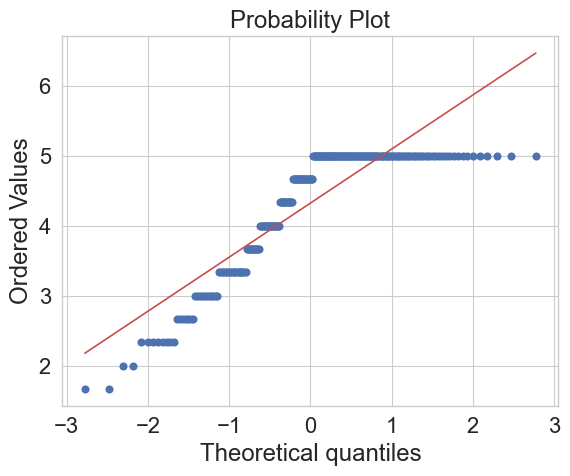

In [603]:
st.probplot(df_data['rating'], dist="norm", plot=pylab)
pylab.show()

Text(0.5, 0, 'Framerate')

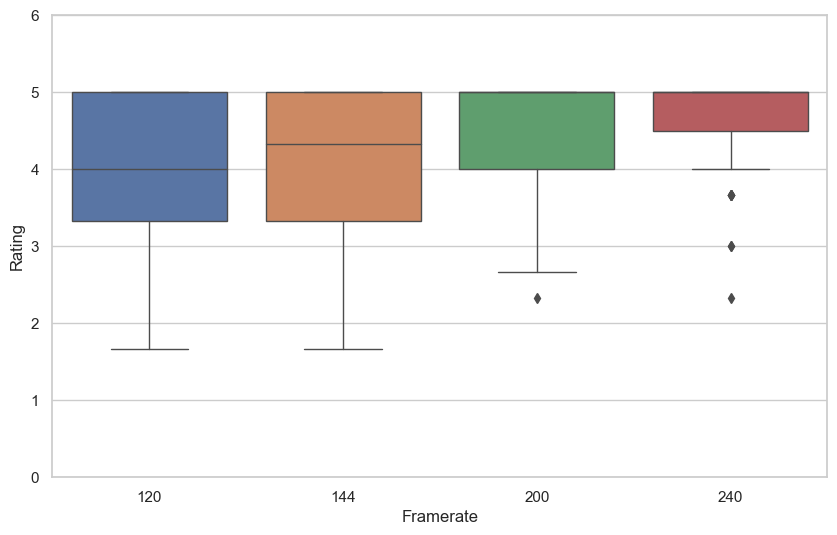

In [604]:
sns.set_palette("colorblind")
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,6))
plt.ylim(0, 6)
plt.gca()

ax = sns.boxplot(data=df_data, x='framerate', y='rating', linewidth=1)
ax.set_ylabel("Rating")
ax.set_xlabel("Framerate")

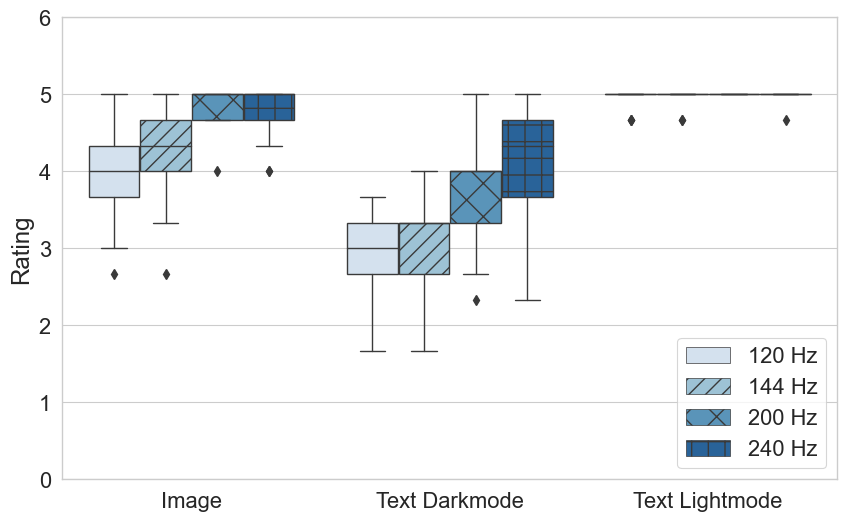

In [605]:
sns.set_theme(style='whitegrid', font_scale=1.8, context='paper')
plt.figure(figsize=(10,6))
plt.ylim(0, 6)
plt.gca()

white_color = ['#ffffff', '#ffffff']

ax = sns.boxplot(data=df_data, x='scene', y='rating', hue="framerate", linewidth=1, palette="Blues")
#ax = sns.swarmplot(data=df_data, x='scene', y='rating', hue="framerate", linewidth=1, alpha=0.5, dodge=True, palette=white_color, edgecolor="black")

ax.set_ylabel("Rating")
ax.set_xlabel("")
ax.set_xticklabels(["Image", "Text Darkmode", "Text Lightmode"])

hatches = ['', '', '//', '//', 'x', 'x', '+', '+','',  '//',   'x', '+','','//', 'x',  '+']

for i, patch in enumerate(ax.patches):
    patch.set_hatch(hatches[i])

handles, labels = ax.get_legend_handles_labels()

labels = ["120 Hz", "144 Hz", "200 Hz", "240 Hz"]
ax.legend(title="", handles=handles, labels=labels, loc='lower right')



(0.0, 6.0)

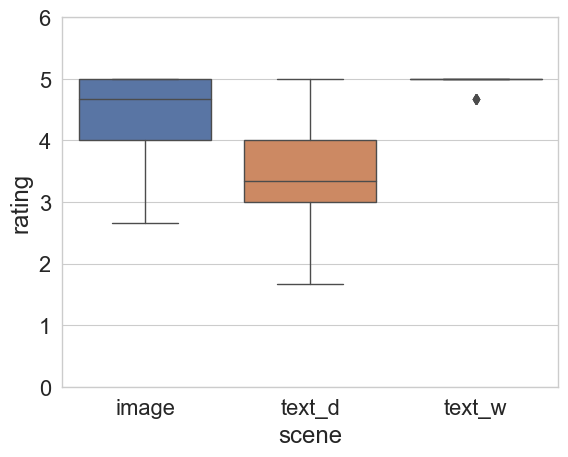

In [606]:
ax = sns.boxplot(data=df_data, x='scene', y='rating', linewidth=1)
plt.ylim(0, 6)


(0.0, 6.0)

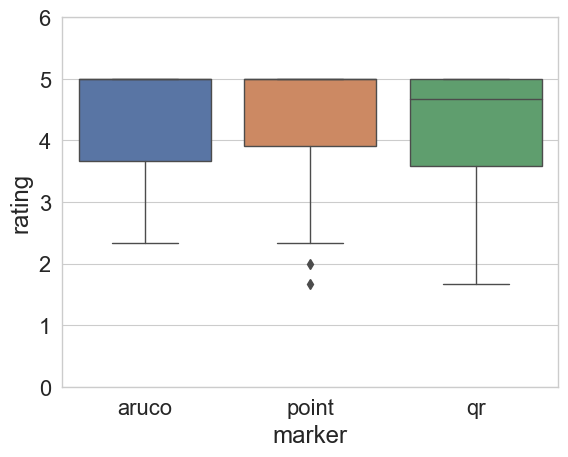

In [607]:
ax = sns.boxplot(data=df_data, x='marker', y='rating', linewidth=1)
plt.ylim(0, 6)


(0.0, 6.0)

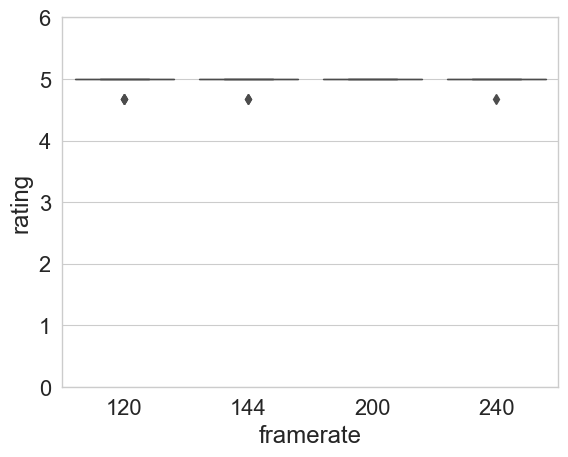

In [608]:
ax = sns.boxplot(data=df_data[df_data['scene'] == 'text_w'], x='framerate', y='rating', linewidth=1)
plt.ylim(0, 6)


(0.0, 6.0)

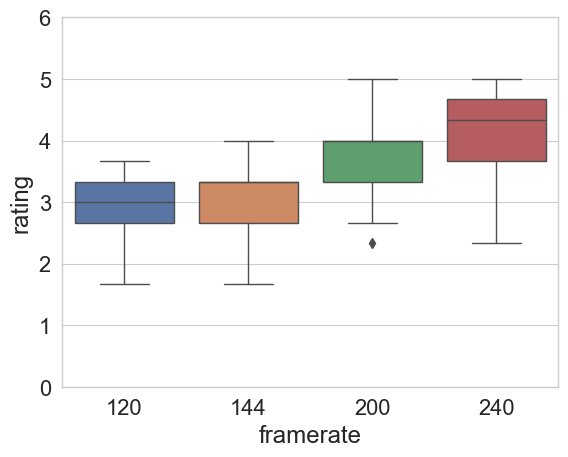

In [609]:
ax = sns.boxplot(data=df_data[df_data['scene'] == 'text_d'], x='framerate', y='rating', linewidth=1)
plt.ylim(0, 6)


(0.0, 6.0)

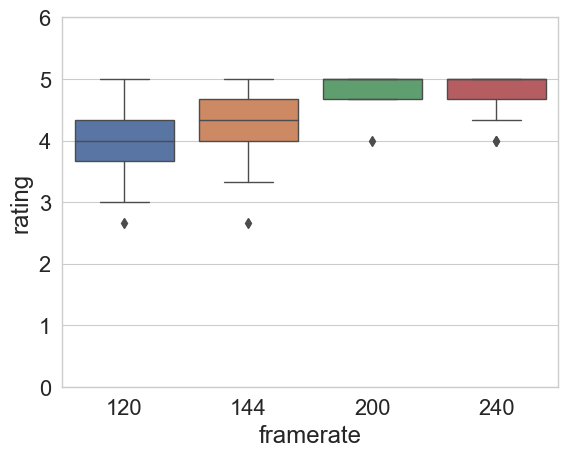

In [610]:
ax = sns.boxplot(data=df_data[df_data['scene'] == 'image'], x='framerate', y='rating', linewidth=1)
plt.ylim(0, 6)


In [611]:
np.corrcoef(df_data[df_data['framerate'] == 120]['rating'], df_data[df_data['framerate'] == 240]['rating'])

array([[1.        , 0.69484348],
       [0.69484348, 1.        ]])

In [612]:
#perform three-way ANOVA
model = ols("""rating ~ C(scene) + C(framerate) + C(marker) +
               C(scene):C(framerate) + C(scene):C(marker) + C(framerate):C(marker) +
               C(scene):C(framerate):C(marker)""", data=df_data).fit()

aov_table = anova_lm(model, typ=2)

eta_squared(aov_table)
omega_squared(aov_table)
print(aov_table.round(3))

                                  sum_sq     df        F  PR(>F)  eta_sq  \
C(scene)                         102.014    2.0  230.906   0.000   0.545   
C(framerate)                      20.314    3.0   30.653   0.000   0.108   
C(marker)                          1.792    2.0    4.056   0.019   0.010   
C(scene):C(framerate)             11.411    6.0    8.609   0.000   0.061   
C(scene):C(marker)                 2.340    4.0    2.649   0.034   0.012   
C(framerate):C(marker)             0.300    6.0    0.226   0.968   0.002   
C(scene):C(framerate):C(marker)    1.420   12.0    0.536   0.890   0.008   
Residual                          47.714  216.0      NaN     NaN     NaN   

                                 omega_sq  
C(scene)                            0.542  
C(framerate)                        0.105  
C(marker)                           0.007  
C(scene):C(framerate)               0.054  
C(scene):C(marker)                  0.008  
C(framerate):C(marker)             -0.005  
C(scene

In [613]:
ttest_result = pg.ttest(df_data[df_data['framerate'] == 144]['rating'],
                        df_data[df_data['framerate'] == 200]['rating'],
                        paired=True)
ttest_result

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.284645,62,two-sided,3.655767e-08,"[-0.58, -0.3]",0.527216,3.55e+05,0.984577
